# Problem Statement

Given an inverted Pendulum of length=1, mass=1, design a controller
so that the damping ratio, $\zeta=0.707$, and the 2\% settling time, $t_s=1$ seconds.

# Dynamics

In [1]:
import control
import sympy
import sympy.physics.mechanics as mech
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

mech.init_vprinting()

In [2]:
# symbols
theta, Q, T = mech.dynamicsymbols('theta, Q, T')
m, l, g, t = sympy.symbols('m, l, g, t')

# frames
frame_e = mech.ReferenceFrame('e')
frame_p = frame_e.orientnew('p', 'Axis', (theta, frame_e.z))
#frame_p.set_ang_vel(frame_e, Q*frame_e.z)

# points
point_a = mech.Point('a')
point_a.set_vel(frame_e, 0)
point_p = point_a.locatenew('p', l*frame_p.x)
point_p.v2pt_theory(point_a, frame_e, frame_p)

# bodies
pendulum = mech.Particle('pendulum', point_p, m)
bodies = [pendulum]

# forces/moments
loads = [
    (point_p, -m*g*frame_e.x),
    (frame_p, T*frame_e.z - 0*Q*frame_e.z)
]


KM = mech.KanesMethod(frame=frame_e, q_ind=[theta], u_ind=[Q], kd_eqs=[theta.diff(t) - Q])
KM.kanes_equations(bodies, loads)

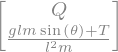

In [3]:
KM.rhs()

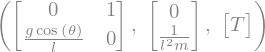

In [5]:
KM.linearize(A_and_B=True)

In [6]:
op_point={m: 1, l: 1, g:9.8, theta: 0, Q: 0}
op_point

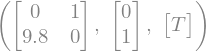

In [7]:
A, B, u = KM.linearize(A_and_B=True, op_point=op_point)
A, B, u

In [8]:
C = np.eye(2)
D = np.zeros((2, 1))
G_simo = control.ss2tf(A, B, C, D)
G_simo

TransferFunction([[array([1.])], [array([1., 0.])]], [[array([ 1. , -0. , -9.8])], [array([ 1. , -0. , -9.8])]])

In [9]:
G = G_simo[0, 0]
G

TransferFunction(array([1.]), array([ 1. , -0. , -9.8]))

# Control Design

In [10]:
def rlocus(G, kvect=np.logspace(-2, 0, 1000), kwargs={}):
    """
    A custom rlocus command to improve some of the plotting
    """
    rlist, klist = control.rlocus(G, kvect=kvect, Plot=False)
    for key in ['rlocus', 'zero', 'pole']:
        if key not in kwargs.keys():
            kwargs[key] = {}

    for z in G.zero():
        plt.plot(np.real(z), np.imag(g), 'o', markeredgewidth=3,  markerfacecolor='none', markersize=20, **kwargs['zero'])

    for z in G.pole():
        plt.plot(np.real(z), np.imag(g), 'x', markeredgewidth=3, markersize=20, **kwargs['pole'])

    for i in range(rlist.shape[1]):
        plt.plot(np.real(rlist[:, i]), np.imag(rlist[:, i]), **kwargs['rlocus'])
    
    plt.xlabel('Real')
    plt.ylabel('Imaginary')

In [12]:
# requirements
zeta = np.sqrt(2)/2
ts = 1

sigma_d = 4/ts
a = np.arccos(zeta)
wd = sigma_d*np.tan(a)
sd = -sigma_d + wd*1j
sd

(-4+3.9999999999999996j)

/home/jgoppert/anaconda3/envs/research/lib/python3.8/site-packages/control/rlocus.py:129: FutureWarning: 'Plot' keyword is deprecated in root_locus; use 'plot'
  warnings.warn("'Plot' keyword is deprecated in root_locus; "


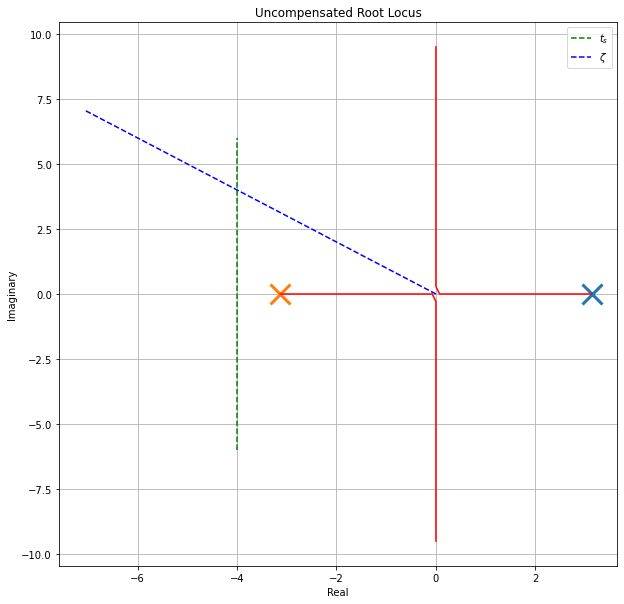

In [13]:
plt.figure(figsize=(10, 10))
rlocus(G, kvect=np.logspace(-2, 2, 1000), kwargs={'rlocus': {'color': 'r'}})
plt.vlines(-sigma_d, -6, 6, color='g', linestyle='--', label='$t_s$')
plt.plot([0, -10*np.cos(a)], [0, 10*np.sin(a)],  'b--', label='$\zeta$')
plt.grid()
plt.legend()
plt.title('Uncompensated Root Locus');

In [14]:
angle_deficiency = np.pi - np.angle(G(sd))
print('angle deficiency: {:4.1f} deg'.format(np.rad2deg(angle_deficiency)))

angle deficiency: 73.0 deg


In [16]:
s = control.tf([1, 0], [1])
z = -np.imag(sd)/np.tan(angle_deficiency) + np.real(sd)
C = (s-z)
K = 1/np.abs((G*C)(sd))
H = C*K
print('K:', K, 'z:', z)

K: 8.0 z: -5.2250000000000005


# Proportional Derivative Controller 

In [17]:
H

TransferFunction(array([ 8. , 41.8]), array([1]))

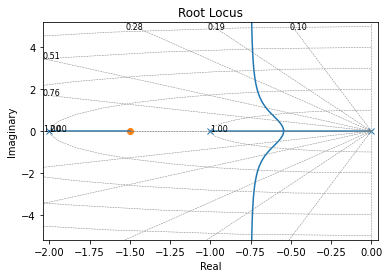

In [18]:
control.rlocus((s+1.5)/(s*(s+2)*(s+1)));

/home/jgoppert/anaconda3/envs/research/lib/python3.8/site-packages/control/rlocus.py:129: FutureWarning: 'Plot' keyword is deprecated in root_locus; use 'plot'
  warnings.warn("'Plot' keyword is deprecated in root_locus; "


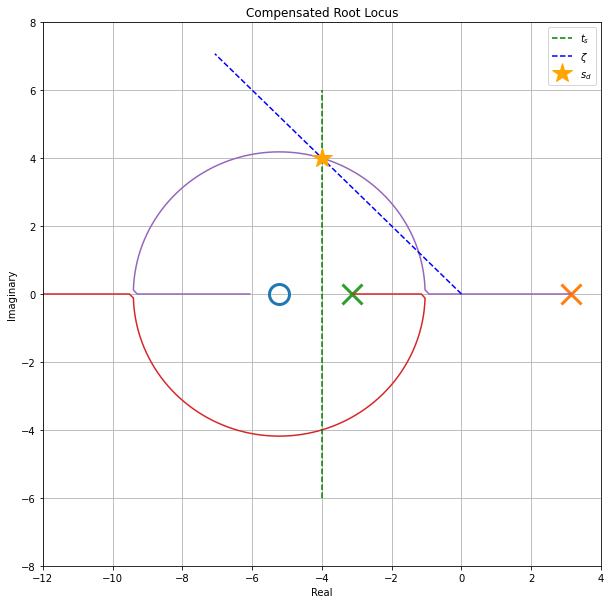

In [19]:
plt.figure(figsize=(10, 10))
rlocus(G*H, kvect=np.linspace(0, 4, 5000))
plt.vlines(-sigma_d, -6, 6, color='g', linestyle='--', label='$t_s$')
plt.plot([0, -10*np.cos(a)], [0, 10*np.sin(a)],  'b--', label='$\zeta$')
plt.plot(np.real(sd), np.imag(sd), '*', label='$s_d$', markersize=20, color='orange')
plt.grid()
plt.legend()
plt.axis([-12, 4, -8, 8]);
plt.title('Compensated Root Locus');

In [20]:
L = G*H
Kp = np.real(L(0))
ess = 1/(1 + Kp)
Gc = G*H/(1 + G*H)
Gc

TransferFunction(array([   8.  ,   41.8 ,  -78.4 , -409.64]), array([   1. ,    8. ,   22.2,  -78.4, -313.6]))

This is the step response of the system, notice that there is a steady state error, to get rid of this, we should have specified a steady state error design requirement. This will require the use of an integrator, which is a full PID controller instead of just a PD controller.

Text(0.5, 1.0, 'unit step response')

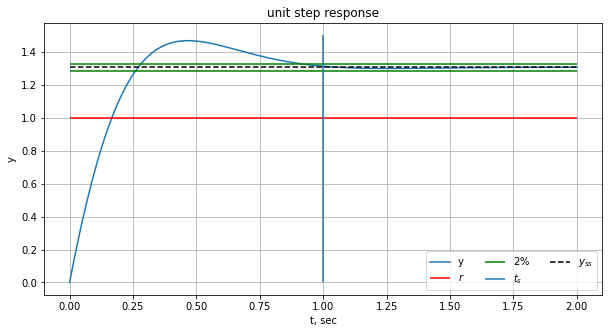

In [21]:
t_step, y_step = control.step_response(Gc, np.linspace(0,2, 1000));
plt.figure(figsize=(10, 5))
plt.plot(t_step, y_step, label='y')
yss = 1 - ess
plt.hlines(1, 0, 2, linestyle='-', color='r', label='$r$')
plt.hlines(0.02 + yss, 0, 2, linestyle='-', color='g', label='$2\%$')
plt.hlines(-0.02 + yss, 0, 2, linestyle='-', color='g')
plt.vlines(ts, 0, 1.5, label='$t_s$')
plt.hlines(1 - ess, 0, 2, linestyle='--', color='k', label='$y_{ss}$')
plt.xlabel('t, sec')
plt.ylabel('y')
plt.grid()
plt.legend(loc='lower right', ncol=3)
plt.title('unit step response')

# Simulation

In [22]:
class Controller:
    """
    Implements a discrete state space model.
    """
    
    def __init__(self, A, B, C, D, dt):
        self.A = A
        self.B = B
        self.C = C
        self.D = D
        self.x = np.zeros((np.shape(A)[0], 1))
    
    def update(self, u):
        self.x = self.A*self.x + self.B*u
        return self.C*self.x + self.D*u
    
    def reset(self):
        self.x = 0

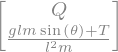

In [23]:
KM.rhs()

In [24]:
import scipy.integrate


def do_sim(r, H, dt):
    x_vect = sympy.Matrix([theta, Q])
    u_vect = sympy.Matrix([T])
    p_vect = sympy.Matrix([m, g, l])
    f_pend = sympy.lambdify([x_vect, u_vect, p_vect], list(KM.rhs()))
    
    Hd = control.tf2ss(control.c2d(H*100/(s+100), dt))
    my_controller = Controller(Hd.A, Hd.B, Hd.C, Hd.D, Hd.dt)
    
    tf = 2
    p = [1, 9.8, 1]
    data = {
        't': [],
        'x': [],
        'u': []
    }
    x0 = np.array([0, 0])
    t0 = 0
    u0 = 0
    for i in range(int(tf/dt)):
        # save data
        data['t'].append(t0)
        data['x'].append(x0)
        data['u'].append(u0)
        
        # calculate control
        u0 = my_controller.update(r - x0[0])[0, 0]
        # saturation of motors
        if u0 > 100:
            u0 = 100
        elif u0 < -100:
            u0 = -100
        
        # integrate equations of motion
        res = scipy.integrate.solve_ivp(lambda t, x: f_pend(x, [u0], p), [t0, t0+dt], x0)
        x0 = res['y'][:, -1]
        t0 = res['t'][-1]
        
    for k in data:
        data[k] = np.array(data[k])
    return data

def plot_sim(r, t_step, y_step, sim_data):
    plt.figure(figsize=(20, 10))
    
    plt.subplot(121)
    plt.plot(sim_data['t'], np.rad2deg(sim_data['x'][:, 0]), label='nonlinear');
    plt.plot(t_step, np.rad2deg(r*y_step), label='linear approx')
    plt.hlines(np.rad2deg(r), 0, 2)
    plt.legend()
    plt.grid()
    plt.title('simulated step response')
    plt.xlabel('t, sec')
    plt.ylabel('$\\theta$, deg')
    
    plt.subplot(122)
    plt.plot(sim_data['t'], sim_data['u']);
    plt.xlabel('t, sec')
    plt.ylabel('T, N-m')
    plt.grid()
    plt.title('input')

    #plt.plot(sim_data['t'], sim_data['u']);

For small angles, the linear approximation let's us design a decent controll for the non-linear system, but the non-linear system has less damping than we would like.

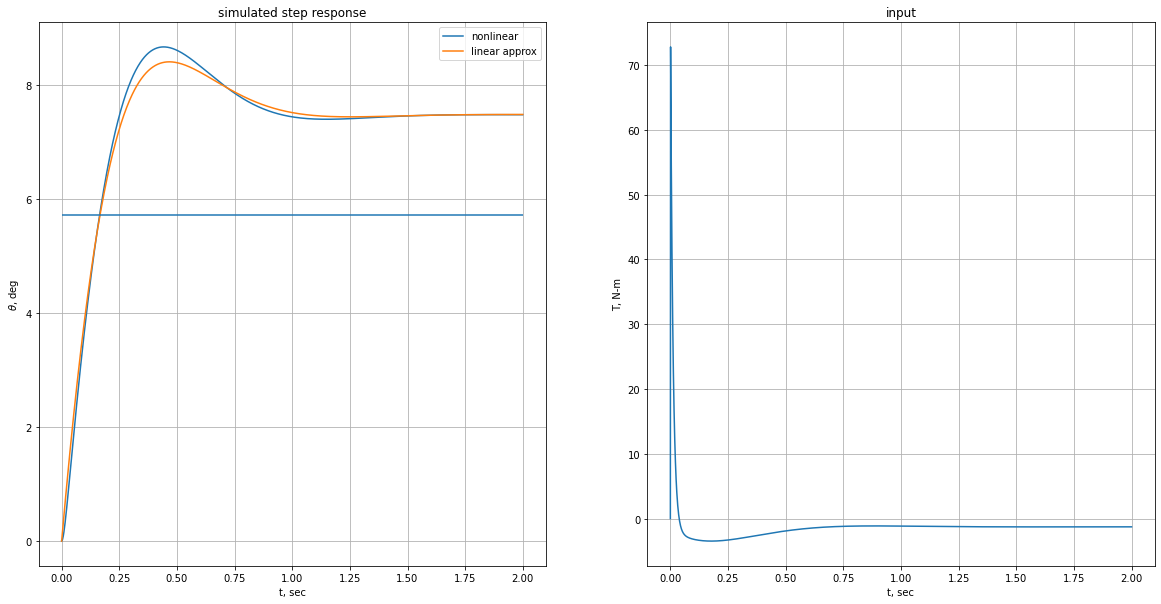

In [37]:
r = 0.1
sim_data = do_sim(r, H, 0.001)
plot_sim(r, t_step, y_step, sim_data)

When the motors saturate, or we are far from the equilibrium point, the linear approximation is very poor.

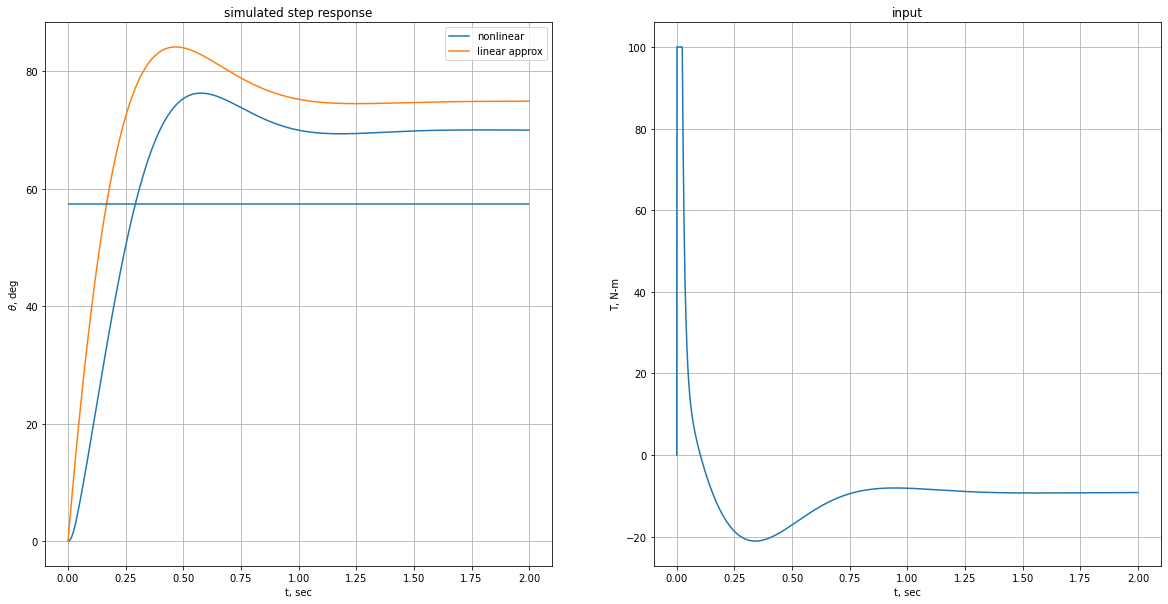

In [30]:
r = 1
sim_data = do_sim(r, H, 0.001)
plot_sim(r, t_step, y_step, sim_data)